In [1]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt, Bool

mi.set_variant('cuda_ad_rgb')

In [2]:
!python3 /home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/generate_cbox.py 4


In [3]:
from radiosity_sh import RadianceCacheMiSH
from radiosity_sh import compute_loss as compute_loss_sh

# scene = mi.load_file("/home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/cbox.xml")
scene = mi.load_file("/home/jonathan/Documents/mi3-balance/scripts/resources/cbox-tessellated/cbox-rgb.xml")
# scene = mi.load_file("/home/jonathan/Documents/mi3-balance/resources/data/scenes/matpreview/matpreview.xml")

sh_order = 3
radiance_cache = RadianceCacheMiSH(scene, sh_order, fit_Nquad=128, fit_spp=64)

Fitting spherical harmonics to scene...


  0%|          | 0/8 [00:00<?, ?it/s]


RuntimeError: drjit.block_reduce(): error encountered while processing an argument of type 'mitsuba.Color3f' (see above).

In [ ]:
from radiosity_sh import SceneSurfaceSampler

scene_sampler = SceneSurfaceSampler(scene)

In [ ]:
from radiosity_rt import RadianceCacheMITSUBA
from radiosity_rt import compute_loss as compute_loss_rt

radiance_cache_exact = RadianceCacheMITSUBA(scene, 256, 128)

In [ ]:
colors = {
    'white': [0.9, 0.7, 0.6],
    'box': [0.5, 0.3, 0.9],
    'red': [0.6, 0.1, 0.1],
    'green': [0.1, 0.4, 0.1],
    'light': [0.9, 0.7, 0.7]
}

mesh_materials = ['light', 'white', 'white', 'white', 'green', 'red', 'box', 'box']

In [ ]:
from vertex_bsdf import Principled, Diffuse

bsdf_train = Principled(specular=0.0)   # TODO: should `specular` also be a trainable parameter?

for idx, mesh in enumerate(scene.shapes()):
    if not(mesh.is_mesh()):
        continue
    bsdf_train.initialize_mesh_attributes(mesh, [0.5, 0.5, 0.5], m_roughness = 0.0, m_metallic = 0.0)


# for idx, (mesh, material) in enumerate(zip(scene.shapes(), mesh_materials)):
#     if not(mesh.is_mesh()):
#         continue
#     bsdf_train.initialize_mesh_attributes(mesh, colors[material], m_roughness = 0.0, m_metallic = 0.0)

# TODO
bsdf_train = Diffuse()

In [ ]:
NUM_GEO_SAMPLES = 1 << 20 # 1 << 14
NUM_WI_DIRECTIONS = 256 << 0

In [ ]:
# compute_loss_mi(scene_sampler, radiance_cache_exact, Principled(specular=0.0), NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, 0)
# compute_loss_mi(scene_sampler, radiance_cache_exact, Diffuse(), NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, 0)
# compute_loss_sh(scene_sampler, radiance_cache, Principled(specular=0.0), NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, 0)
# compute_loss_sh(scene_sampler, radiance_cache, Diffuse(), NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, 0)

In [ ]:
# bsdf1 = Diffuse()
# bsdf2 = Principled(False, specular=0.0)

# N = 4
# sampler_rt = mi.load_dict({'type' : 'independent'})
# sampler_rt.seed(3, wavefront_size=N)
# si = scene_sampler.sample(N, sampler_rt, 4)[0]
# wi = mi.warp.square_to_cosine_hemisphere(sampler_rt.next_2d())
# sample1 = sampler_rt.next_1d()
# sample2 = sampler_rt.next_2d()

# bsdf_ref = si.shape.bsdf() 
# print("eval():", dr.allclose(
#     bsdf1.eval(mi.BSDFContext(), si, wi),
#     bsdf_ref.eval(mi.BSDFContext(), si, wi)))

# print("pdf():", dr.allclose(
#     bsdf1.pdf(mi.BSDFContext(), si, wi),
#     bsdf_ref.pdf(mi.BSDFContext(), si, wi)))

# print("sample().color:", dr.allclose(
#     bsdf1.sample(mi.BSDFContext(), si, sample1, sample2)[1],
#     bsdf_ref.sample(mi.BSDFContext(), si, sample1, sample2)[1]))
# print("sample().bs.wo:", dr.allclose(
#     bsdf1.sample(mi.BSDFContext(), si, sample1, sample2)[0].wo,
#     bsdf_ref.sample(mi.BSDFContext(), si, sample1, sample2)[0].wo))
# print("sample().bs.pdf:", dr.allclose(
#     bsdf1.sample(mi.BSDFContext(), si, sample1, sample2)[0].pdf,
#     bsdf_ref.sample(mi.BSDFContext(), si, sample1, sample2)[0].pdf))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.7265298].


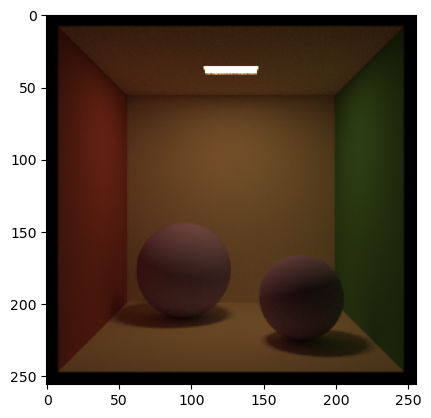

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(mi.render(scene) ** (1 / 2.2))

In [ ]:
# from vertex_bsdf import visualize_textures

# visualize_textures(scene)

In [ ]:
from time import time

params = mi.traverse(scene)
# keys = [key for key in params.keys() if "vertex_bsdf" in key]
keys = [key for key in params.keys() if "vertex_bsdf_base_color" in key]    # TODO
opt = mi.ad.Adam(lr=0.05)
for key in keys:
    dr.enable_grad(params[key])
    opt[key] = params[key]
    params.update(opt)

losses = []
for it in range(200):
    time1 = time()

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss_sh(scene_sampler, radiance_cache, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, it)
    # loss = compute_loss_rt(scene_sampler, radiance_cache_exact, bsdf_train, 
    #     NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, it)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    for key in keys:
        opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time()
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

Iteration 001 [0.702274]: Loss = [0.0292231]
Iteration 002 [0.440106]: Loss = [0.0317969]
Iteration 003 [0.437080]: Loss = [0.0333855]
Iteration 004 [0.438149]: Loss = [0.0321207]
Iteration 005 [0.434438]: Loss = [0.0321081]
Iteration 006 [0.438635]: Loss = [0.0335359]
Iteration 007 [0.442198]: Loss = [0.0302284]
Iteration 008 [0.443228]: Loss = [0.0305952]
Iteration 009 [0.439032]: Loss = [0.0325031]
Iteration 010 [0.441630]: Loss = [0.0333292]
Iteration 011 [0.447840]: Loss = [0.033117]
Iteration 012 [0.448162]: Loss = [0.0333039]
Iteration 013 [0.441024]: Loss = [0.0345534]
Iteration 014 [0.441575]: Loss = [0.0332176]
Iteration 015 [0.442702]: Loss = [0.0323324]
Iteration 016 [0.447304]: Loss = [0.0347084]
Iteration 017 [0.442904]: Loss = [0.0316548]
Iteration 018 [0.441112]: Loss = [0.0299454]
Iteration 019 [0.443146]: Loss = [0.0337648]
Iteration 020 [0.458739]: Loss = [0.030566]
Iteration 021 [0.455515]: Loss = [0.0284578]
Iteration 022 [0.449229]: Loss = [0.0342961]
Iteration 02

In [ ]:
# loss = compute_loss_rt(scene_sampler, radiance_cache_exact, bsdf_train, 
#     NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, it)

# # Backpropagate through the rendering process
# dr.backward(loss)



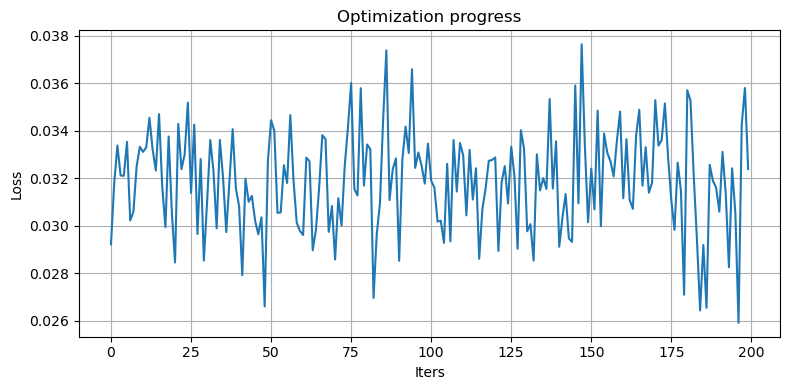

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,4))
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()

In [ ]:
# si = dr.zeros(mi.SurfaceInteraction3f)
# shape_idx = 4
# vtx_idx = 101
# mesh = scene.shapes()[shape_idx]
# si = dr.zeros(mi.SurfaceInteraction3f)
# si.p = mesh.vertex_position(95)
# si.n = mesh.vertex_normal(95)
# si.sh_frame = mi.Frame3f(si.n)
# si.wi = mi.Vector3f([0],[0],[1])
# si.shape = mi.ShapePtr(mesh)
# si

In [ ]:
from principled_bsdf import visualize_textures

visualize_textures(scene)

In [ ]:
# from sh_fitting import visualize_fit

# visualize_fit(scene, sh_order)